# Exploration 10
---
## 인공지능으로 세상에없던 새로운 패션 만들기

생성모델링 --> 없던 데이터를 생성새 내는 것이 목표

Pix2Pix --> 간단한 이미지를 입력할 경우 실제 사진처럼 바꿔주는 모델<br><br>
사용예시)
- 스케치로 그려진 그림을 실사화하기
- 흑백 사진을 컬러로 변환하기
- 위성사진을 지도 이미지로 변환하기
- 낮에 찍힌 사진을 밤 배경의 사진으로 변환하기

Pix2Pix 이후 발전된 모델 __CycleGAN__

<br>
차이점)

- Pix2Pix는 한 방향으로의 변환만 가능하지만, CycleGAN은 양방향으로의 변환을 할 수 있다.
- Pix2Pix는 입력 데이터와 출력 데이터끼리 쌍으로 이루어진 데이터셋이 필요하지만, CycleGAN은 필요 없다.

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.6.0


In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [3]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [4]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [5]:
train_x.shape

(50000, 32, 32, 3)

딥러닝에서 이미지를 다루려면 채널수에 대한 차원이 필요.<br>
입력되는 이미지 데이터의 채널 수는 어떤 이미지냐에 따라 달라짐.<br>
컬러 이미지의 경우 R,G,B 세 개의 채널 존재, 흑백의 경우 1개의 채널만 존재.<br>
본 프로젝트의 데이터는 컬러 이미지이므로 마지막에 채널 수에 해당하는 '3'을 추가해주기


In [6]:
train_x = train_x.reshape(train_x.shape[0], 32, 32, 3).astype('float32')
train_x.shape

(50000, 32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


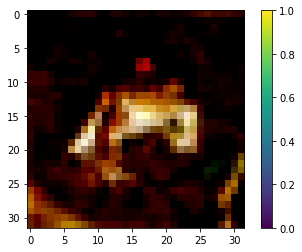

In [7]:
plt.imshow(train_x[0].reshape(32, 32, 3))
plt.colorbar()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

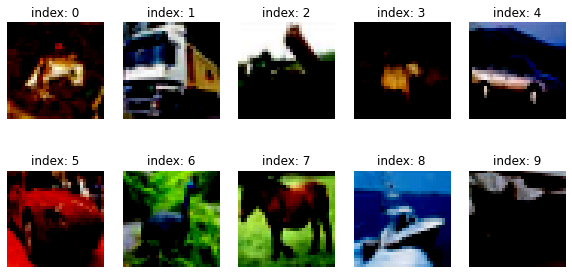

In [8]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1) # (row, column, index)
    plt.imshow(train_x[i].reshape(32, 32, 3))
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

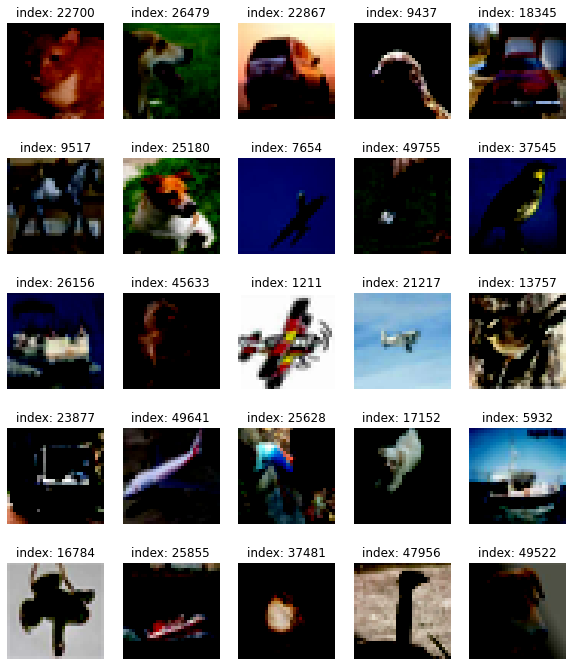

In [9]:
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow(train_x[random_index].reshape(32, 32, 3))
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

In [10]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [11]:
# shuffle() 을 이용하여 데이터 셋 섞어주기
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [12]:
def make_generator_model(): #                    # 언제든 생성자를 생성할 수 있도록 하기

    # Start
    model = tf.keras.Sequential()                # 모델을 시작한 후 레이어 쌓아주기

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())   # 신경망의 가중치가 폭발하지 않도록 가중치 값 정규화
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer        # 이미지 사이즈를 넓혀주는 층. 세 번동안 8 -> 16 -> 32 순으로 이미지 키워나가기
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    
    
    
    
    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [13]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

In [14]:
# 가우시안 분포에서 뽑아낸 랜덤벡터로 일워진 노이즈 벡터를 생성
noise = tf.random.normal([1, 100])

In [15]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


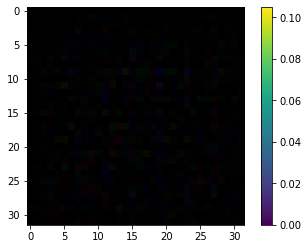

In [16]:
plt.imshow(generated_image[0, :, :])
plt.colorbar()
plt.show()

### 판별자 설계
---
판별자 ; 가짜 이미지와 진짜 이미지를 입력받으면 각 이미지 별로 '진짜라고 판단하는 정도' 를 출력하는 역할

In [17]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [18]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [19]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.0034086]], dtype=float32)>

GAN은 손실함수로 교차 엔트로피를 사용한다. <br>
교차 엔트로피는 앞서 분류모델을 설꼐할 때 많이 사용했던 손실함수. 점점 가까워지기 원하는 두 값의 차이가 얼마나 차이가 나는지 정량적으로 계산할 때 많이 쓰인다. <br>
생성자는 자기가 생성한 __Fake Image__ 를 판별자가 진짜라고 판단하도록 속이고 싶어하며, 판별자는 생성자가 생성한 이미지를 정확하게 판별하는것이 목표.<br>
Real Image --> 1, Fake Image --> 0 이라고 했을 때,
- 생성자 : 판별자가 Fake Image에 대해 판별한 값, 즉 D(fake_image) 값이 1에 가까워지는 것
- 판별자 : Real Image 판별값, 즉 D(real_image)는 1에, Fake Image 판별값, 즉 D(fake_image)는 0에 가까워지는 것

따라서 손실함수에 들어간느 값은 모두 판별자의 판별값이 된다. <br>

In [20]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [21]:
vector = [[1, 2, 3],
          [4, 5, 6]]

tf.ones_like(vector)

# tf.ones_like(), tf.zeros_like()위 함수들은 특정 벡터와 동일한 크기면서 값은 1 또는 0으로 가득 채워진 벡터를 만들고 싶을 대 사용한다.

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 1, 1],
       [1, 1, 1]], dtype=int32)>

`generator_loss`는 `fake_output`이 1에 가까워지기를 바라므로, `tf.ones_like`과의 교차엔트로피값을 계산하면된다. <br>
즉, `cross_entropy(tf.ones_like(fake_output), fake_output)` 값은 fake_output이 (Real Image 를 의미하는) 1에 가까울수록 작은 값을 가짐.

In [22]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

반면, `discriminator_loss`는 `real_output`값은 1에 가까워지기를, `fake_output` 값은 0에 가까워지기를 바라므로, 두 가지 loss 값을 모두 계산한다. `real_output`은 1로 채워진 벡터와, `fake_output`은 0으로 채워진 벡터와 비교하면 된다.

In [23]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [24]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

ex.) real_output = tf.Tensor([0.2, 0.4, 0.7, 0.9]) 라면,

(1) tf.math.greater_equal(real_output, tf.constant([0.5]) : real_output의 각 원소가 0.5 이상인지 True, False로 판별 - >> tf.Tensor([False, False, True, True])<br>
(2) tf.cast( (1), tf.float32) : (1)의 결과가 True이면 1.0, False이면 0.0으로 변환 - >> tf.Tensor([0.0, 0.0, 1.0, 1.0])<br>
(3) tf.reduce_mean( (2)) : (2)의 결과를 평균내어 이번 배치의 정확도(accuracy)를 계산 - >> 0.5


In [25]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [26]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [27]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [28]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i,:,:])      # 채널 수를 맞추기 위해
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [29]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [30]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## 모델학습

In [31]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [32]:
save_every = 5
EPOCHS = 500

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

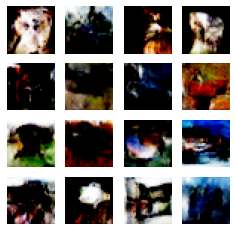

Time for training : 8550 sec


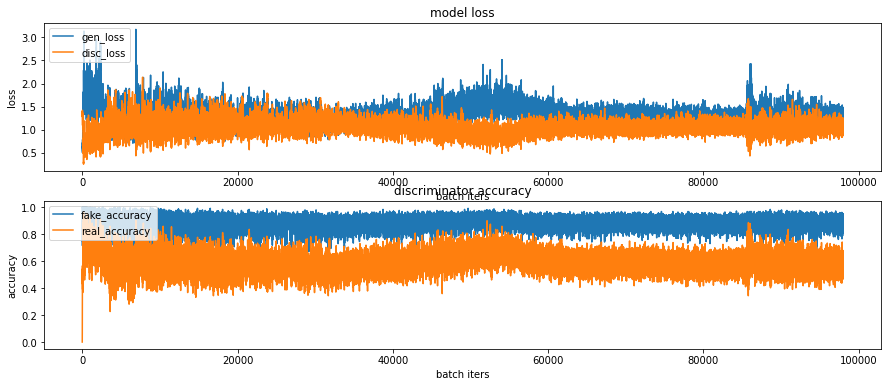

CPU times: user 2h 33min 18s, sys: 14min 15s, total: 2h 47min 33s
Wall time: 2h 22min 36s


In [33]:
%%time
train(train_dataset, EPOCHS, save_every)

In [34]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif

-rw-r--r-- 1 root root 2504446 Feb 12 14:23 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif


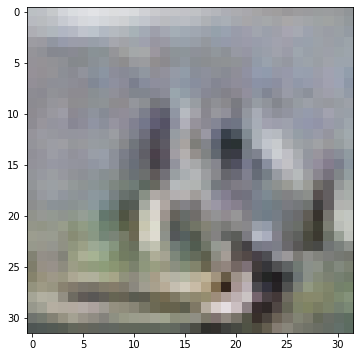

In [36]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인.
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것이다.

In [2]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.6.0


# 후기


## 1. 모델에 대한 평가

 이번 프로젝트는 GAN 모델을 이용하여 기존의 이미지를 학습하여 새로운 이미지를 생성하는 프로젝트이다. 기존의 노드와 달리 cifar10에 내장되어 있는 데이터셋을 이용하였다. 

기존에 잘 알려진 GAN 모델의 성능을 향상시키는 방법은 다음과 같다.
- Strided Convolutions 사용하기
- Fully-Connected Layers 제거하기
- Batch Normalization 사용하기
- Relu 계열, Tanh 활성화 함수 사용하기

이 외에도 여러가지 방법이 있지만 이번 프로젝트의 기존 베이스라인에서는 위 내용을 상당부분 포함하고 있어 사이즈만 조절해 준 코드, Conv2D 레이어를 하나 더 쌓은 코드, LeakyReLU의 alpha 값을 0.02로 설정한 코드 총 세가지로 테스트 하였다. 



![](https://8888-w67de9lgjurpt0w09blmsfe1u.e.prod.connect.ainize.ai/files/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif)

![](https://8888-w67de9lgjurpt0w09blmsfe1u.e.prod.connect.ainize.ai/files/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_2.gif)

![](https://8888-w67de9lgjurpt0w09blmsfe1u.e.prod.connect.ainize.ai/files/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_3.gif)

위 gif 이미지의 결과는 앞서 말한 코드의 순서대로이다. 코드에서 출력된 이미지 뿐만 아니라 다른 이미지들 또한 관찰했을 때 무언가 형상을 나타내는 것 같으면서도 그게 무엇인지에 대해서는 설명을 잘 못할 정도의 이미지가 생성되었다. 

gif 파일로 나타낸 결과물은 아래와 같다.



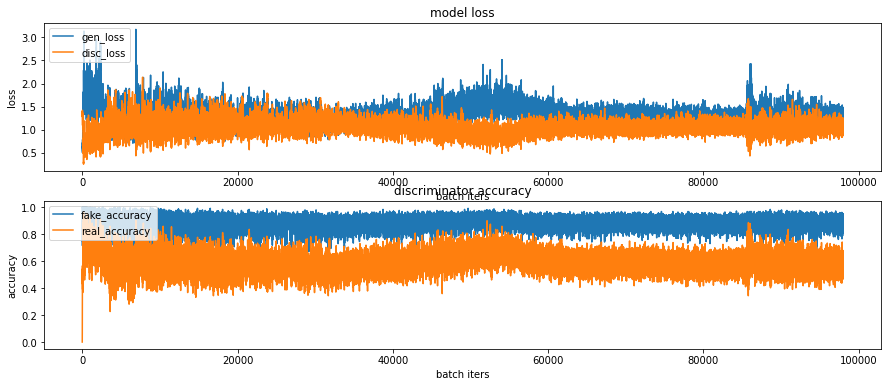

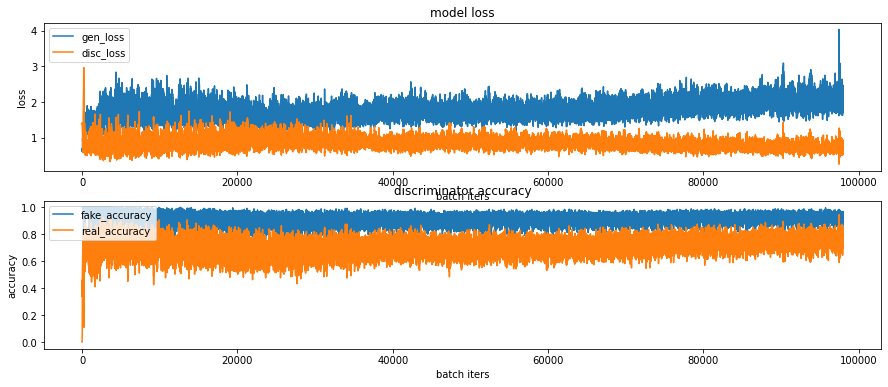

(alpha = 0.02 로 설정한 코드에 대한 결과 그래프가 사라져서 첨부하지 못했지만 위 그래프보다 더 좋지않은 결과였다.)


두 그래프를 보면 accuracy에 대해서는 큰 차이는 아니지만 conv2D 레이어를 추가한 결과물에 비하여 기존 베이스코드를 이용한 것이 fake accuracy 가 0.5에 더 가까웠다. (두 모델 모두 0.5에 가까워지는 것으로 보이진 않는다...) 반면 loss는 accuracy에 비해 두 모델 간의 차이가 꽤 큰 차이가 나타나는 것을 볼 수 있다.


## 2. 후기

이번 프로젝트는 학습에 소요되는 시간이 여태 진행했던 노드들에 비해서 굉장히 많이 걸리는 편이라 코드를 실행시키는 것이 많이 부담스러운 프로젝트였다. 또한 모델의 성능을 끌어올리는데에 있어 기존 베이스라인 코드가 내눈에는 기존에 알려진 방법들을 잘 따르고 있는 것 같아 어떤 것을 손봐야 할지에 대해서 많이 의문이 들었던 것 같다. 노드를 진행할 때 소개한 GAN을 활용한 이미지 생성예시를 보고 굉장히 흥미로웠는데 결과물은 다소 기대했던 것과 달라 많이 아쉬웠던 것 같다. 여러모로 CV 분야를 계속해서 공부한다면 자주 만날 것 으로 보이는 모델인 것 같은데 다음에 활용하게 될 때는 더 좋은 결과물이 나오기를 바란다.